In [ ]:
!pip install yfinance
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
start_date = "2024-01-01"
end_date = "2024-10-15"

#Crawl dữ liệu
azn = yf.Ticker("AZN.L")
historical_data = azn.history(start=start_date, end=end_date)

historical_data.to_csv("AZN_L_2024.csv")

In [ ]:
data = pd.read_csv("AZN_L_2024.csv")[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])

scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

# Tạo cột giá Close cho ngày hôm trước
data['Close_Lag1'] = data['Close'].shift(1)
data.dropna(inplace=True)

# Chia dữ liệu
X = data[['Close_Lag1']]
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
train_data = pd.DataFrame(X_train)
train_data['Close'] = y_train

test_data = pd.DataFrame(X_test)
test_data['Close'] = y_test

train_data.to_csv('AZN_train.csv', index=False)
test_data.to_csv('AZN_test.csv', index=False)
# Huấn luyện mô hình Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
# Dự đoán
y_pred_lr = model_lr.predict(X_test)

y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))  # thực tế
y_pred_lr= scaler.inverse_transform(y_pred_lr.reshape(-1, 1))  # dự đoán
predicted_dates = data['Date'].iloc[len(data) - len(y_test):]
predicted_results = pd.DataFrame({
    'Date': predicted_dates,
    'Obs Close': y_test.flatten(),
    'Predicted Close': y_pred_lr.flatten()
})
print(predicted_results)

                          Date  Obs Close  Predicted Close
160  2024-08-19 00:00:00+01:00    13050.0     13058.606575
161  2024-08-20 00:00:00+01:00    13102.0     13062.599639
162  2024-08-21 00:00:00+01:00    13000.0     13114.509466
163  2024-08-22 00:00:00+01:00    13018.0     13012.686343
164  2024-08-23 00:00:00+01:00    13076.0     13030.655130
165  2024-08-27 00:00:00+01:00    13158.0     13088.554553
166  2024-08-28 00:00:00+01:00    13200.0     13170.412357
167  2024-08-29 00:00:00+01:00    13274.0     13212.339525
168  2024-08-30 00:00:00+01:00    13274.0     13286.211203
169  2024-09-02 00:00:00+01:00    13276.0     13286.211203
170  2024-09-03 00:00:00+01:00    13190.0     13288.207734
171  2024-09-04 00:00:00+01:00    13046.0     13202.356866
172  2024-09-05 00:00:00+01:00    12540.0     13058.606575
173  2024-09-06 00:00:00+01:00    12650.0     12553.484025
174  2024-09-09 00:00:00+01:00    12712.0     12663.293275
175  2024-09-10 00:00:00+01:00    12406.0     12725.1857

<ipython-input-63-106aeb5eeab1>:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


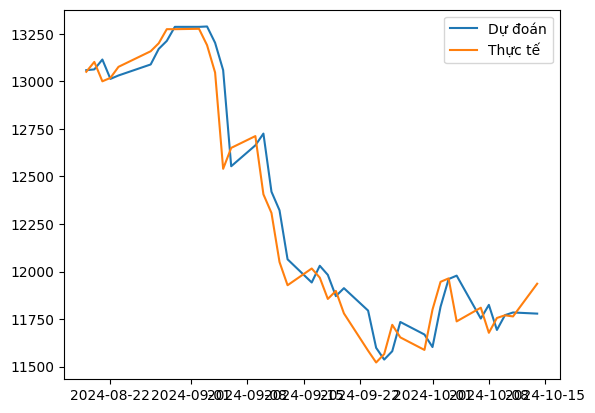

In [ ]:
plt.plot(data['Date'].iloc[len(data) - len(y_test):],y_pred_lr.flatten())
plt.plot(data['Date'].iloc[len(data) - len(y_test):],y_test.flatten())
plt.legend(['Dự đoán','Thực tế'])



In [ ]:
input_data = data[['Close']].iloc[-1:].values  # Lấy giá trị của ngày gần nhất (15/10)
input_data = input_data.reshape(1, -1)  # Đảm bảo rằng dữ liệu đầu vào có dạng 2D

predicted_price = model_lr.predict(input_data)  # model_lr là mô hình Linear Regression đã huấn luyện
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))  # Chuyển đổi về giá trị gốc
print(f"Dự đoán giá cổ phiếu cho ngày 16/10 bằng Linear Regression: {predicted_price.flatten()[0]}")


Dự đoán giá cổ phiếu cho ngày 16/10 bằng Linear Regression: 11950.531415946287


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
def create_sequences(data, sequence_length=1):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Tạo dữ liệu chuỗi thời gian
sequence_length = 7
X_seq, y_seq = create_sequences(data['Close'].values, sequence_length)

#chia dữ liệu
split_index = int(0.8 * len(X_seq))
X_train_rnn, X_test_rnn = X_seq[:split_index], X_seq[split_index:]
y_train_rnn, y_test_rnn = y_seq[:split_index], y_seq[split_index:]
print(len(X_test_rnn),len(y_test_rnn))

X_train_rnn = X_train_rnn.reshape(-1, sequence_length, 1)
X_test_rnn = X_test_rnn.reshape(-1, sequence_length, 1)

#RNN
model_rnn = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

#Huấn luyện mô hình RNN
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_train_rnn, y_train_rnn, epochs=50, batch_size=16)


y_pred_rnn = model_rnn.predict(X_test_rnn)


#y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
#y_test_rnn = scaler.inverse_transform(y_test_rnn.reshape(-1, 1))

predicted_dates = data['Date'].iloc[len(data) - len(y_test_rnn):]
predicted_results_rnn = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': y_pred_rnn.reshape(-1, 1).flatten(),'Obs Close': y_test_rnn.flatten()})


print(predicted_results_rnn)

39 39
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4652
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2964 
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1992 
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0697 
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079  
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019     
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020  
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013     
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 
Epoch 

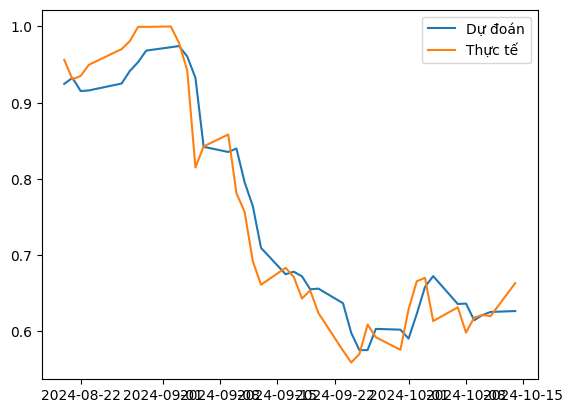

In [ ]:
plt.plot(data['Date'].iloc[len(data) - len(y_test_rnn):],y_pred_rnn.flatten())
plt.plot(data['Date'].iloc[len(data) - len(y_test_rnn):],y_test_rnn.flatten())
plt.legend(['Dự đoán','Thực tế'])
